# Aim

1. train a decision tree model

In [21]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dtreeviz.trees import *
from sklearn import tree
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [2]:
DATA_ROOT = f"../data"

In [3]:
df_train = pd.read_pickle(f"{DATA_ROOT}/train/model/data.pkl")
df_test = pd.read_pickle(f"{DATA_ROOT}/test/model/data.pkl")

df_train.head()

,zip_25_0,zip_02_0,kw_Accident,kw_Northbound,kw_Hwy,kw_ramp,kw_slow,kw_Trl,kw_Mopac,kw_Okeechobee,...,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,zip_len,zip_is_compound,Severity
0,1,1,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,5,False,3
1,2,2,1,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,5,False,3
2,2,2,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,5,False,2
3,3,1,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,10,True,2
4,4,2,1,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,5,False,2


1. We need to split train dataset into train set and cross validation set.
1. Since our model has been sorted on time stamps we cannot use k-fold cv
1. as that will hamper the order of data

---
`NOTE` using single CV set for this assignment

In [6]:
x_train, y_train = df_train.iloc[:, :-1], df_train.iloc[:, -1]

In [9]:
x_train, x_cv, y_train, y_cv = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=False
)

In [12]:
x_train.shape, y_train.shape

((2379544, 108), (2379544,))

In [13]:
x_cv.shape, y_cv.shape

((594886, 108), (594886,))

In [133]:
x_test, y_test = df_test.iloc[:, :-1], df_test.iloc[:, -1]

# Evaluation setup

## Precision Recall matrix

<img src="https://www.mdpi.com/technologies/technologies-09-00081/article_deploy/html/images/technologies-09-00081-g001.png" width="800" height="400">

1. We need to boost values of diagonal elements in the confusion matrix
1. In order to monitor the performance of our models we can create Precision Recall Matrices
1. Where in we divide Confusion matrix by
    - sum of confusion matrix across rows -> to get Precision matrix
    - sum of confusion matrix across columns -> to get Recall matrix

In [14]:
# demo
cm = confusion_matrix([1, 0, 1, 0, 1, 0, 0], [1, 1, 0, 1, 0, 1, 0])
cm

array([[1, 3],
       [2, 1]])

In [15]:
cm / cm.sum(axis=0)  # precision matrix -> dividing by predicted positives

array([[0.33333333, 0.75      ],
       [0.66666667, 0.25      ]])

In [108]:
(cm.T / cm.sum(axis=1)).T  # recall matrix -> dividing by actual positives

array([[0.25      , 0.75      ],
       [0.66666667, 0.33333333]])

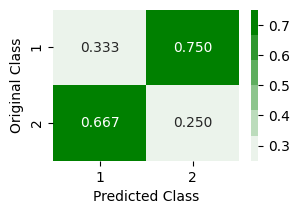

In [110]:
plt.figure(figsize=(3, 2), dpi=100)
cmap = sns.light_palette("green")
labels = [1, 2]
sns.heatmap(
    cm / cm.sum(axis=0),
    annot=True,
    cmap=cmap,
    fmt=".3f",
    xticklabels=labels,
    yticklabels=labels,
)
plt.xlabel("Predicted Class")
plt.ylabel("Original Class")
plt.show()

In [112]:
np.seterr(divide="ignore", invalid="ignore")


def get_pr_matrix(y_true, y_pred):
    """
    Get precision recall matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    # avoid nans in matrix, replace with 0
    pr_matrix = cm / cm.sum(axis=0)
    pr_matrix = np.nan_to_num(pr_matrix)
    re_matrix = (cm.T / cm.sum(axis=1)).T
    re_matrix = np.nan_to_num(re_matrix)

    return pr_matrix, re_matrix


def plot_matrix_heatmap(mat, labels=[1, 2, 3, 4], title="None"):
    plt.figure(figsize=(4, 1), dpi=150)
    plt.title(title)
    cmap = sns.light_palette("green")
    sns.heatmap(
        mat, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels,
    )
    plt.xlabel("Predicted Class")
    plt.ylabel("Original Class")
    plt.show()


def plot_pr_matrix_heatmaps(y_true, y_pred):
    p, r = get_pr_matrix(y_true, y_pred)

    plot_matrix_heatmap(p, title="Precision Matrix")
    plot_matrix_heatmap(r, title="Recall Matrix")

Ideally how should a Precision Recall matrix look?

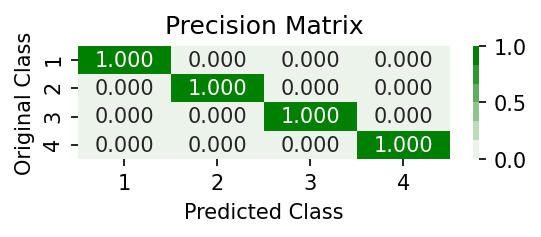

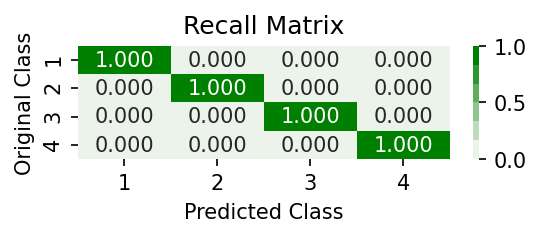

In [19]:
plot_pr_matrix_heatmaps(y_train, y_train)

## Log loss

In [22]:
# demo
log_loss(
    [0, 1, 1, 0],  # true labels
    [[0.1, 0.9], [0.8, 0.2], [0.1, 0.9], [0.3, 0.7]],  # probability scores
)

1.3053390813529768

# Random model performance

Let us check how a random model performs. Our decision tree should atleast perform better than random model.

In [24]:
k_train = x_train.shape[0]
y_train_pred_random = np.random.randint(low=1, high=5, size=k_train)

## Random model Precision Recall matrix

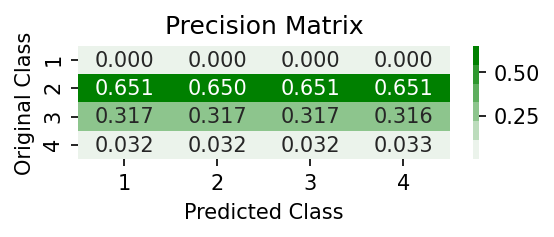

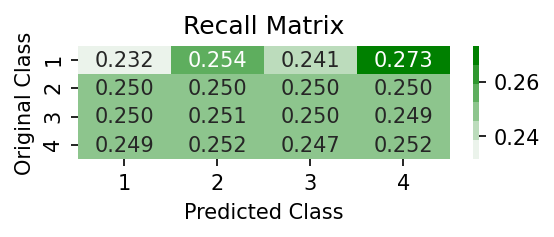

In [113]:
plot_pr_matrix_heatmaps(y_train, y_train_pred_random)  # on train set

1. From recall matrix it is evident that performance of random model is random in nature
1. all the classes are being classified and missclassified with same percentage
1. similar result can be observed in precision matrix

## Random model Logloss

In [26]:
random_log_loss_train = log_loss(
    y_train,
    [np.random.rand(1, 4)[0] for i in range(y_train.shape[0])],
    labels=[1, 2, 3, 4],
)  # on train set


print(
    f"log loss on predicting probabilities randomly on test set {random_log_loss_train}"
)

log loss on predicting probabilities randomly on test set 1.6454627287245502


## Observations on random model

1. random model is giving log loss around 1.64 in both train and test
1. our decision tree should give a better log loss i.e <1.64 

# Training loop

## Class weight

1. each class has a different number of occurences
1. adding class weight will handle imabalances in the labels distributions


In [27]:
"""
for "balanced" 
w = n_samples / (n_classes * np.bincount(y))
"""

classes = [1, 2, 3, 4]
w = compute_class_weight("balanced", classes=classes, y=y_train,)
class_weights = {i: j for i, j in zip(classes, w)}

# get value counts
value_counts = df_train["Severity"].value_counts().to_dict()

In [28]:
print("value_counts of labels in train set:")
print(dict(sorted(value_counts.items(), key=lambda x: x[0])))

print("\nweights of labels:")
print(dict(sorted(class_weights.items(), key=lambda x: x[0])))

value_counts of labels in train set:
{1: 969, 2: 1993515, 3: 887615, 4: 92331}

weights of labels:
{1: 706.5154394299287, 2: 0.3841190881137882, 3: 0.7897401721565233, 4: 7.7527758953239845}


There is a high imbalance in dataset. Class `1` has very low number of training examples.

Hyperparameter chosen for tuning model : `max_depth`

In [114]:
max_depth = [5, 10, 12, 15, 18, 20]

errors_log = []
for d in max_depth:
    print(f"{'-'*30} max_depth={d} {'-'*30}")

    clf = tree.DecisionTreeClassifier(max_depth=d, class_weight=class_weights)
    clf = clf.fit(x_train, y_train)

    # get log los train
    ll_train = log_loss(y_train, clf.predict_proba(x_train), labels=[1, 2, 3, 4])
    # get pr matrix train
    p_train, r_train = get_pr_matrix(y_train, clf.predict(x_train))

    # get log los cv set
    ll_test = log_loss(y_cv, clf.predict_proba(x_cv), labels=[1, 2, 3, 4])
    # get pr matrix cv set
    p_test, r_test = get_pr_matrix(y_cv, clf.predict(x_cv))

    # append logs to dictionary

    obj = {
        "max_depth": d,
        "log_loss_train": ll_train,
        "log_loss_cv": ll_test,
        "p_train": p_train,
        "r_train": r_train,
        "p_test": p_test,
        "r_test": r_test,
    }
    errors_log.append(obj)

    print(f"log loss train {obj['log_loss_train']:.4f}")
    print(f"log loss cv {obj['log_loss_cv']:.4f}")

------------------------------ max_depth=5 ------------------------------
log loss train 1.0597
log loss cv 1.0803
------------------------------ max_depth=10 ------------------------------
log loss train 0.9199
log loss cv 0.9192
------------------------------ max_depth=12 ------------------------------
log loss train 0.8483
log loss cv 0.8962
------------------------------ max_depth=15 ------------------------------
log loss train 0.7082
log loss cv 1.1280
------------------------------ max_depth=18 ------------------------------
log loss train 0.5553
log loss cv 1.7039
------------------------------ max_depth=20 ------------------------------
log loss train 0.4657
log loss cv 2.2831


## Plot train cv losses

In [117]:
l = []
for i in errors_log:
    l.append([i["max_depth"], i["log_loss_train"], i["log_loss_cv"]])
l = np.array(l)
l

array([[ 5.        ,  1.05969125,  1.08028904],
       [10.        ,  0.9198995 ,  0.91923486],
       [12.        ,  0.84829702,  0.89621954],
       [15.        ,  0.70816129,  1.12801279],
       [18.        ,  0.55532408,  1.70394803],
       [20.        ,  0.46567863,  2.283116  ]])

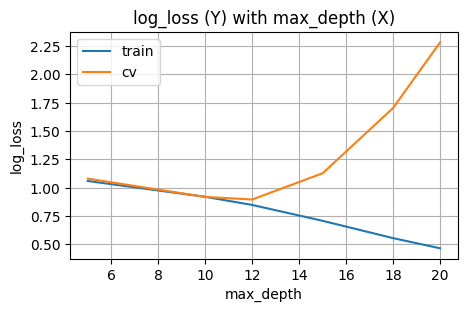

In [151]:
plt.figure(figsize=[5, 3], dpi=100)
plt.title("log_loss (Y) with max_depth (X)")
plt.plot(l[:, 0], l[:, 1])
plt.plot(l[:, 0], l[:, 2])

plt.ylabel("log_loss")
plt.xlabel("max_depth")
plt.grid()
plt.legend(["train", "cv"])
plt.show()

1. We can observe that model starts overfitting after max_depth > 12
1. choosing 12 as best hyper paramter

## Plot PR matrix of best params

In [119]:
p_train = errors_log[2]["p_train"]
r_train = errors_log[2]["r_train"]
p_cv = errors_log[2]["p_test"]  # this key should be p_cv please ignore this
r_cv = errors_log[2]["r_test"]  # this key should be r_cv please ignore this

### Train

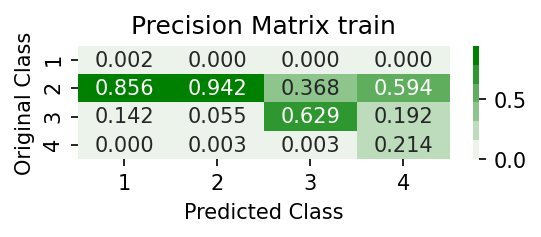

In [120]:
plot_matrix_heatmap(p_train, title="Precision Matrix train")

1. predictions of class 1 actually belonged to class 1 only 0.2% times
    1. 85.6% mis-classifications belonged to class 2
    1. 14.2% mis-classifications belonged to class 3
    
1. predictions of class 2 actually belonged to class 2 94.2% times
    1. 5.5% mis-classifications belonged to class 3
    1. 0.3% mis-classifications belonged to class 4
    1. this is due to imbalance in the labels

1. similar observations can be made for class 3 and 4
1. due to extremely less train samples with class 1 we are not able to predict it well

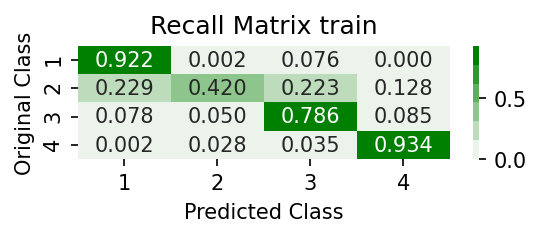

In [121]:
plot_matrix_heatmap(r_train, title="Recall Matrix train")

1. 92% of actual class 1 items were predicted as class 1
1. 42% of actual class 2 items were predicted as class 2
    1. mis-classifications seen across class 1,3,4
1. 78% of actual class 3 items were predicted as class 3
1. 93.4% of actual class 4 items were predicted as class 4

1. Recall of model on all classes except class 2 is fairly good as compared to Precision

### CV

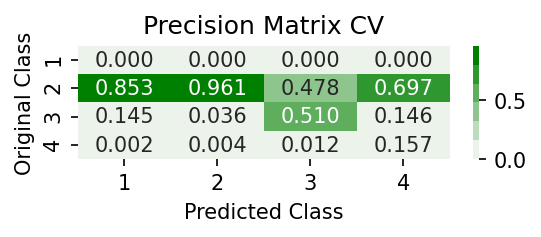

In [122]:
plot_matrix_heatmap(p_cv, title="Precision Matrix CV")

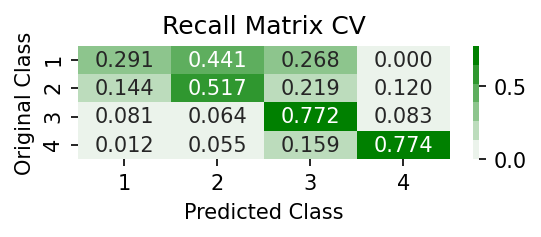

In [123]:
plot_matrix_heatmap(r_cv, title="Recall Matrix CV")

1. Predictions on cross validation set also shows similar precision recall matrices
1. similar observations can be made as for the train set

# Re-train on best params 
using complete train set [train + cv]

In [126]:
x_train_full = pd.concat([x_train, x_cv], axis=0, ignore_index=True)

In [128]:
x_train.shape[0] + x_cv.shape[0] == x_train_full.shape[0]

True

In [129]:
y_train_full = pd.concat([y_train, y_cv], axis=0, ignore_index=True)

In [130]:
y_train.shape[0] + y_cv.shape[0] == y_train_full.shape[0]

True

In [131]:
# train on complete train set
clf = tree.DecisionTreeClassifier(max_depth=12, class_weight=class_weights)
clf = clf.fit(x_train_full, y_train_full)

In [132]:
# save model
pd.to_pickle(clf, f"{DATA_ROOT}/dtree-12.pkl")

# Predict on test set

In [134]:
y_pred_test = clf.predict(x_test)

In [137]:
ll_test = log_loss(y_test, clf.predict_proba(x_test), labels=[1, 2, 3, 4])
print(f"Test log loss {ll_test}")

Test log loss 2.852740179426046


1. We can see that model has performed poorly on test data (looking at the log loss train)
1. It means the model has not generalised well
1. or model is seeing completely different samples which it has not seen earlier
1. or better modelling technique needs to be employed to learn the patterns of data better

# Plot PR matrix of test predictions

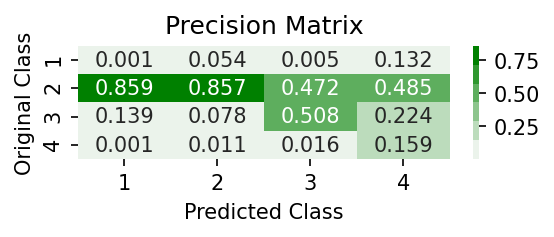

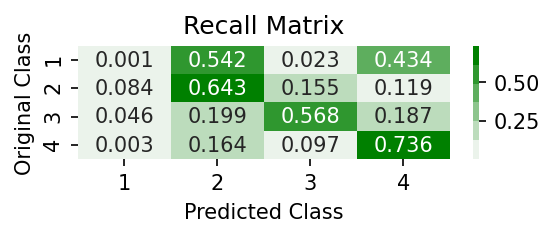

In [138]:
plot_pr_matrix_heatmaps(y_test, y_pred_test)

1. In precision matrix we can see that
    - 85% predictions of label 1 actually belonged to class 2
        - this might also be because of the class_weight that was introduced
    - 85% of predictions of label 2 actually belonged to class 2
        - precision on class 2 is high because it is the most occuring class
1. In recall matrix we can see that
    - 54% of predictions that actually belonged to class 1 are being marked as class 2
    - 43% of predictions that actually belonged to class 1 are being marked as class 4
    - similar observations can be made for other classes

In [153]:
y_test.value_counts()

2    379695
3    111298
1     28205
4     19989
Name: Severity, dtype: int64

In [155]:
y_train_full.value_counts()

2    1993515
3     887615
4      92331
1        969
Name: Severity, dtype: int64

1. If we look at label distributions of train and test set
    - we can clearly see there is major difference in the occurence of class 1
1. This can be root cause of high log loss and poor precision recall on test set

# Interpretating predictions

In [145]:
fn = x_train.columns
cn = [str(i) for i in [1, 2, 3, 4]]
for ix in np.random.randint(low=0, high=x_train.shape[0], size=5):
    print("Predicted class ", clf.predict([x_train.iloc[ix]]))
    print("Actual class ", [y_train[ix]], "\n")

    print("Path taken:\n")
    print(
        explain_prediction_path(
            clf,
            df_train.iloc[ix, :-1],
            feature_names=fn,
            class_names=cn,
            explanation_type="plain_english",
        ),
    )
    print("-" * 30)

Predicted class  [2]
Actual class  [2] 

Path taken:

zip_02_0 < 84.0
kw_ramp < 0.5
0.5 <= Astronomical_Twilight_0 
Timezone_2 < 0.5
State_1 < 0.5
0.5 <= State_4 
0.5 <= Side_1 
Source_0 < 0.5
0.0 <= Distance(mi)  < 1.07
Traffic_Signal < 0.5
zip_len < 7.5

------------------------------
Predicted class  [1]
Actual class  [2] 

Path taken:

2.5 <= zip_02_0  < 15.5
County_2 < 0.5
City_1 < 0.5
0.5 <= Source_0 
Distance(mi) < 0.01
29.74 <= Pressure(in) 
3.5 <= Visibility(mi) 
Wind_Speed(mph) < 17.65
Traffic_Signal < 0.5
7.5 <= zip_len 

------------------------------
Predicted class  [4]
Actual class  [2] 

Path taken:

zip_02_0 < 72.0
Astronomical_Twilight_1 < 0.5
0.5 <= Timezone_1 
Timezone_2 < 0.5
State_1 < 0.5
City_3 < 0.5
Side_0 < 0.5
Source_0 < 0.5
1.07 <= Distance(mi)  < 1.88
zip_len < 7.5

------------------------------
Predicted class  [2]
Actual class  [2] 

Path taken:

47.0 <= zip_02_0  < 82.5
kw_Northbound < 0.5
kw_Trl < 0.5
State_3 < 0.5
0.5 <= State_4 
0.5 <= Source_0 
232.5